In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
from scipy.interpolate import interp2d

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : b-m8WtN4 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

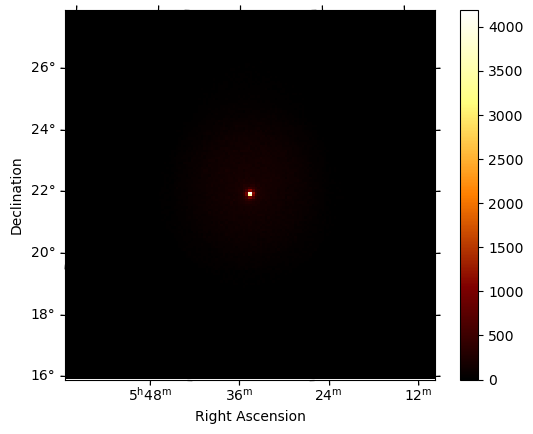

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

In [4]:


def compute_fraction(Ls_new, x_new,
               y_new, threshold, plot = False):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    outside = Ls_new* (Ls_new < offset)
    inside = Ls_new* (Ls_new >= offset)
    fraction_inside = np.sum(inside)/ tot_int
    fraction=  (tot_int - np.sum(outside))/ tot_int 
    if plot:
        fig,ax = plt.subplots(1,1, )
        im =ax.pcolormesh(x_new,
               y_new,
               Ls_new)
        fig.colorbar(im);
        ax.set_title(f"frac inside : {fraction_inside * 100:.4} %")

        CS = ax.contour(x_new,
               y_new,Ls_new, colors=('gold',), levels = [Ls_new.min() + threshold])    
    return fraction_inside

def plot_L(Ls_new, x_new, y_new, threshold, find_min = True, color = 'red'):
    index_min, index_max,  ampli_min,  ampli_max, index_best, ampli_best = compute_errors(
        Ls_new, x_new, y_new, threshold, find_min = find_min )
    fig,ax = plt.subplots(1,1, )
    im =ax.pcolormesh(x_new,
       y_new,
       Ls_new)
    fig.colorbar(im);

    CS = ax.contour(x_new,
       y_new,Ls_new, colors=('gold',), levels = [ Ls_new.min() + threshold]) 
    linewidth = 2
    ax.hlines(y = index_min, xmin = x_new[0], xmax = x_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)
    ax.hlines(y = index_max, xmin = x_new[0], xmax = x_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)

    ax.vlines(x = ampli_min, ymin = y_new[0], ymax = y_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)
    ax.vlines(x = ampli_max, ymin = y_new[0], ymax = y_new[-1], color = color,
             linestyle = 'dotted', linewidth = linewidth)

    ax.plot(ampli_best, index_best, 'x')

    plt.xlabel("amplitude")
    plt.ylabel("index")
    return CS
    
    
def compute_errors(Ls_new, x_new,
               y_new, threshold , find_min = False):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    outside = Ls_new* (Ls_new < offset)
    inside = Ls_new* (Ls_new >= offset)
    if find_min: # find min:
        pos = np.where(inside >= 0 )
        ampli_best = x_new[np.where(Ls_new == Ls_new.min())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.min())[0][0]]
        
    else:  # find max
        pos = np.where(inside > 0 )
        ampli_best = x_new[np.where(Ls_new == Ls_new.max())[1][0]]
        index_best = y_new[np.where(Ls_new == Ls_new.max())[0][0]]
        
    delta_bin = (x_new[1] - x_new[0] )/2
    ampli_min = x_new[np.min(pos[1])]-delta_bin
    ampli_max = x_new[np.max(pos[1])]+delta_bin
    ampli_best += delta_bin
    
    delta_bin = (y_new[1] - y_new[0] )/2
    index_min = y_new[np.min(pos[0])]-delta_bin
    index_max = y_new[np.max(pos[0])]+delta_bin
    index_best += delta_bin
    
    print(ampli_best, index_best)
    return index_min, index_max,  ampli_min,  ampli_max, index_best, ampli_best
    

## Varying the Exposure

In [5]:
savefig = False
factor = +0.
sigma = 0.1

In [6]:
infos = np.loadtxt("data/6a_P_draw_info.txt")
pars = np.loadtxt("data/6a_P_draw_par.txt")
flux = np.loadtxt("data/6a_P_draw_flux.txt")
flux2e = np.loadtxt("data/6a_P_draw_flux2e.txt")


N = len(infos)
print(N)

factor_rnds = infos[:,0]
stat_sums = infos[:,1]


#amplitude', 'index', 'norm', 'tilt
amplitudes = pars[:,0:2] 
indices = pars[:,2:4] 
norms = pars[:,4:6]
tilt = pars[:,6:8]

valuies = [norms, amplitudes, indices]




1000


In [7]:
sys_d_cor = sys_dataset(dataset_asimov, factor, False)
dataset_asimov = sys_d_cor.create_dataset()
dataset_asimov_N = sys_d_cor.create_dataset_N()

penalising_covmatrix = [[1/sigma**2]]
penalising_invcovmatrix =  penalising_covmatrix
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix


fit_cor = Fit(store_trace=False)

result_cor = fit_cor.run([dataset_asimov])    
result_cor_N = fit_cor.run([dataset_asimov_N]) 
#dataset_asimov_N.models[0].parameters['amplitude_nuisance'].frozen = True

4
4


In [8]:
valuies_asimov = [[dataset_asimov.models[1].parameters['norm'].value, 
                   dataset_asimov.models[1].parameters['norm'].error],
                  [dataset_asimov.models[0].parameters['amplitude'].value, 
                   dataset_asimov.models[0].parameters['amplitude'].error],
                  [dataset_asimov.models[0].parameters['index'].value, 
                   dataset_asimov.models[0].parameters['index'].error],]


valuies_asimov_N = [[dataset_asimov_N.models[1].parameters['norm'].value, 
                   dataset_asimov_N.models[1].parameters['norm'].error],
                  [dataset_asimov_N.models[0].parameters['amplitude'].value, 
                   dataset_asimov_N.models[0].parameters['amplitude'].error],
                  [dataset_asimov_N.models[0].parameters['index'].value, 
                   dataset_asimov_N.models[0].parameters['index'].error],]

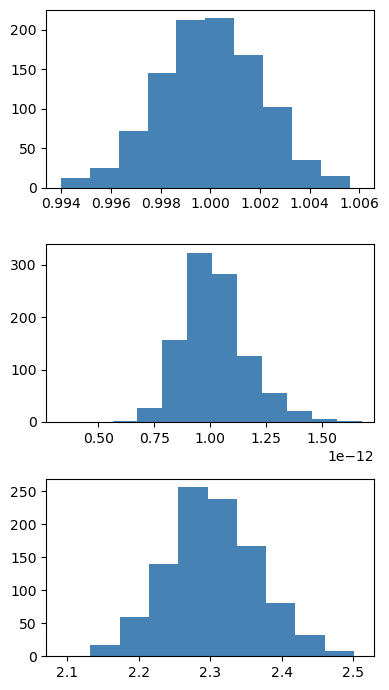

In [9]:
fig, axs = plt.subplots(3,1, figsize = (4,7))
xlabels = ["Best Fit BKG Norm", "Best Fit Amplitude", "Best Fit Index"]

for i, v in enumerate(valuies):
    axs[i].hist(v[1:,0], color ='steelblue')
    
    x = axs[i].get_xlim()
    deltax = np.max([ valuies_asimov[i][0] - x[0] , x[1] - valuies_asimov[i][0] ])
    axs[i].set_xlim(valuies_asimov[i][0] -deltax, 
                    valuies_asimov[i][0] + deltax)
    
plt.tight_layout()



## Asimov Likelihood

Source.spectral.amplitude_scan
Source.spectral.index_scan
stat_scan
fit_results
1.049756660199392e-12
2.3342868732046407
CPU times: user 2min 30s, sys: 166 ms, total: 2min 30s
Wall time: 2min 31s


Text(0.5, 1.0, 'Likelihood')

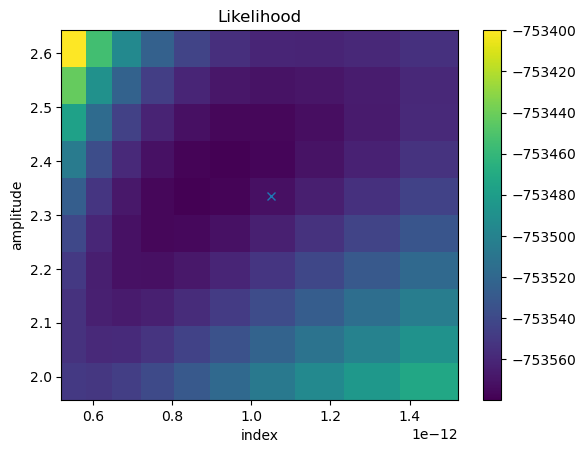

In [59]:
%%time
computing = False
if computing:

    x = dataset_asimov.models.parameters['amplitude']
    y = dataset_asimov.models.parameters['index']
    x.scan_n_sigma = 5
    y.scan_n_sigma = 5
    x.scan_n_values = 10
    y.scan_n_values = 10

    contour = fit_cor.stat_surface([dataset_asimov], x, y, reoptimize=True) 

    contour_write = dict()
    for k in contour.keys():
        print(k)
        if k != 'fit_results':
            contour_write[k]  = contour[k].tolist()
            
    with open('data/6c_contour.yml' , 'w') as outfile:
        yaml.dump(contour_write, outfile, default_flow_style=False)
        
else:
    with open('data/6c_contour.yml', 'r') as stream:
        contour=yaml.safe_load(stream)
        
x__ = contour['Source.spectral.amplitude_scan']
y__ = contour['Source.spectral.index_scan']
N_new = 80
N_new_i = N_new
x_contour =  np.linspace(x__[0], x__[-1],N_new)
y_contour =  np.linspace(y__[0], y__[-1],N_new_i)


f = interp2d(x = x__, y= y__, z = contour['stat_scan'], kind='cubic',fill_value = None, bounds_error = False )
data_contour = f(x_contour, y_contour)

fig, ax = plt.subplots()
im =ax.pcolormesh(x__, y__, contour['stat_scan'])


dddd = np.array(contour['stat_scan'])

ampli_best = x__[np.where(dddd == dddd.min())[1][0]]
index_best = y__[np.where(dddd == dddd.min())[0][0]]

print(ampli_best)
print(index_best)

ax.plot(ampli_best, index_best, 'x')


fig.colorbar(im, ax=ax)

plt.ylabel("amplitude")
plt.xlabel("index",)
plt.title(f"Likelihood")

8.97669113917491e-13 2.3703097906221746
8.97669113917491e-13 2.3703097906221746


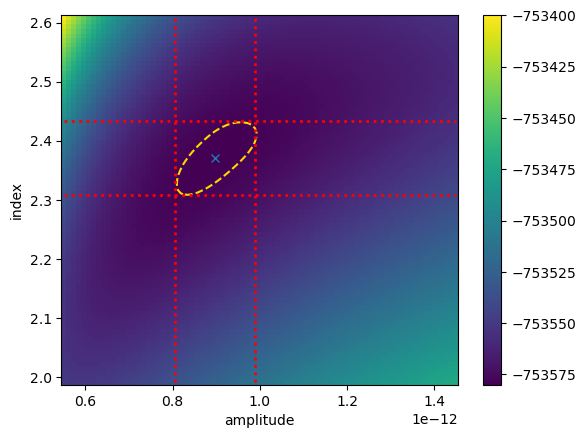

In [62]:
threshold_contour = 1
index_min_asimov, index_max_asimov,  ampli_min_asimov,  ampli_max_asimov, index_best_asimov, ampli_best_asimov= compute_errors(
    data_contour, x_contour, y_contour,  threshold_contour, find_min = True)

CS= plot_L(data_contour, x_contour,
           y_contour,  threshold_contour,
      find_min = True, color = 'red')

dat= CS.allsegs[0][0]

## Asimov Likelihood N

SourceN.spectral.amplitude_scan
SourceN.spectral.index_scan
stat_scan
fit_results
CPU times: user 3min 49s, sys: 214 ms, total: 3min 49s
Wall time: 3min 50s


Text(0.5, 1.0, 'Likelihood')

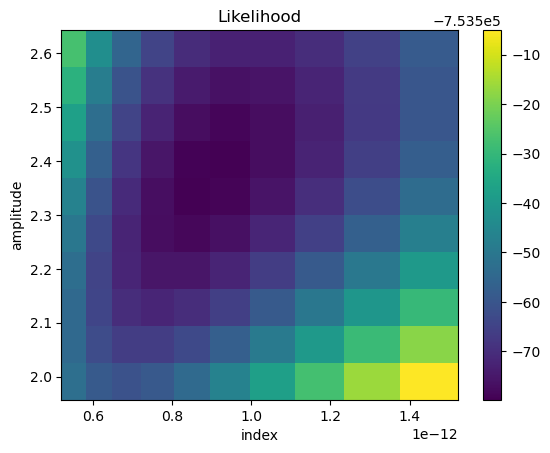

In [63]:
%%time
compute_N = False
if compute_N:
    x_N = dataset_asimov_N.models.parameters['amplitude']
    y_N = dataset_asimov_N.models.parameters['index']

    x_N.scan_values = np.array(x__)
    y_N.scan_values = np.array(y__)

    contour_N = fit_cor.stat_surface([dataset_asimov_N], x_N, y_N, reoptimize=True ) 


    contour_write = dict()
    for k in contour_N.keys():
        print(k)
        if k != 'fit_results':
            contour_write[k]  = contour_N[k].tolist()
            
    with open('data/6c_contour_N.yml' , 'w') as outfile:
        yaml.dump(contour_write, outfile, default_flow_style=False)
        
else:
    with open('data/6c_contour_N.yml', 'r') as stream:
        contour_N=yaml.safe_load(stream)
        
x__ = contour_N['SourceN.spectral.amplitude_scan']
y__ = contour_N['SourceN.spectral.index_scan']
x_contour_N =  np.linspace(x__[0], x__[-1],N_new)
y_contour_N =  np.linspace(y__[0], y__[-1],N_new_i)


f = interp2d(x = x__, y= y__, z = contour_N['stat_scan'], kind='cubic',fill_value = None, bounds_error = False )
data_contour_N = f(x_contour_N, y_contour_N)

fig, ax = plt.subplots()
im =ax.pcolormesh(x__, y__ ,  contour_N['stat_scan'])

fig.colorbar(im, ax=ax)

plt.ylabel("amplitude")
plt.xlabel("index",)
plt.title(f"Likelihood")

8.97669113917491e-13 2.378121989580194
8.97669113917491e-13 2.378121989580194


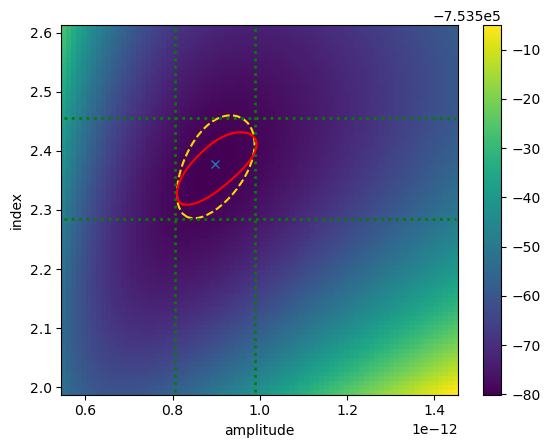

In [65]:
threshold_contour = 1
index_min_asimov_N, index_max_asimov_N,  ampli_min_asimov_N,  ampli_max_asimov_N, index_best_asimov_N, ampli_best_asimov_N= compute_errors(
    data_contour_N, y_contour_N, x_contour_N,  threshold_contour, find_min = True)

CS_N  = plot_L(data_contour_N, y_contour_N, x_contour_N,  threshold_contour,  find_min = True, color = 'green')
dat_N = CS_N.allsegs[0][0]
plt.plot(dat[:,0],dat[:,1], color = 'red')
#plt.plot(dat_N[:,0],dat_N[:,1], color = 'green')

## Compute fraction of within

In [66]:
def fraction_within(lower_lim, upper_lim, data):
    is_within = []
    for d in data:
        larger = np.all(d[0] >= lower_lim )
        smaller = np.all(d[0] <= upper_lim)
        is_within.append(larger and smaller)
        
    return (np.count_nonzero(is_within) / len(data))
    

In [67]:
# std best fit, nui best fit, ... 
within_norm = [fraction_within(valuies_asimov[0][0] - valuies_asimov[0][1],
                               valuies_asimov[0][0] +  valuies_asimov[0][1],
                               norms
                              ),
               fraction_within(valuies_asimov_N[0][0] - valuies_asimov_N[0][1],
                               valuies_asimov_N[0][0] + valuies_asimov_N[0][1],
                               norms
                              ),
               0., 0.,
              ]

within_amplitude = [fraction_within(valuies_asimov[1][0] - valuies_asimov[1][1],
                               valuies_asimov[1][0] +  valuies_asimov[1][1],
                               amplitudes
                              ),
               fraction_within(valuies_asimov_N[1][0] - valuies_asimov_N[1][1],
                               valuies_asimov_N[1][0] + valuies_asimov_N[1][1],
                               amplitudes
                              ),
               fraction_within(ampli_min_asimov,
                               ampli_max_asimov,
                               amplitudes
                              ),
                fraction_within(ampli_min_asimov_N,
                               ampli_max_asimov_N,
                               amplitudes
                              ),
                ]

within_index = [fraction_within(valuies_asimov[2][0] - valuies_asimov[2][1],
                               valuies_asimov[2][0] +  valuies_asimov[2][1],
                               indices
                              ),
               fraction_within(valuies_asimov_N[2][0] - valuies_asimov_N[2][1],
                               valuies_asimov_N[2][0] + valuies_asimov_N[2][1],
                               indices
                              ),
                fraction_within(index_min_asimov,
                               index_max_asimov,
                               indices
                              ),
                fraction_within(index_min_asimov_N,
                               index_max_asimov_N,
                               indices
                              ),]

withins = [within_norm, 
          within_amplitude,
          within_index]
print(withins)

[[0.685, 0.685, 0.0, 0.0], [0.512, 0.738, 0.41, 0.41], [0.668, 0.668, 0.422, 0.608]]


0 Best Fit BKG Norm
1 Best Fit Amplitude
2 Best Fit Index


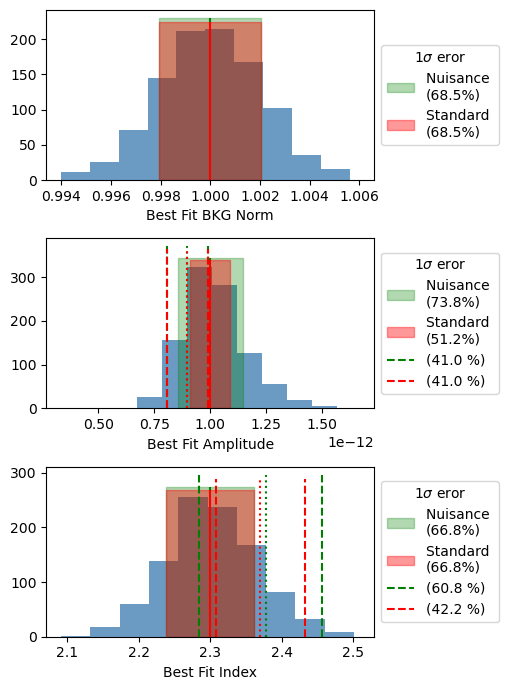

In [68]:
fig, axs = plt.subplots(3,1, figsize = (4,7))
xlabels = ["Best Fit BKG Norm", "Best Fit Amplitude", "Best Fit Index"]
legends = ["Nuisance",'Standard',   ]

for i, v in enumerate(valuies):
    print(i, xlabels[i])
    axs[i].hist(v[1:,0], color ='steelblue', alpha = 0.8)
    ylim = axs[i].get_ylim()
    delta_ylim = 5
    
    axs[i].vlines(valuies_asimov_N[i][0], ylim[0], ylim[1]+ delta_ylim, color = 'green', 
                 linestyle= 'dashed', )
    axs[i].fill_between([valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
                         valuies_asimov_N[i][0] + valuies_asimov_N[i][1]]
                        , ylim[0], ylim[1]+ delta_ylim,
                       alpha = 0.3, color = 'green', 
                        label = legends[0] + f' \n({withins[i][1]*100 :.3}%)')
    axs[i].vlines(valuies_asimov[i][0], ylim[0], ylim[1], color = 'red')
    axs[i].fill_between([valuies_asimov[i][0] - valuies_asimov[i][1],
                         valuies_asimov[i][0] + valuies_asimov[i][1]]
                        , ylim[0], ylim[1],
                       alpha = 0.4 , color = 'red', 
                        label = legends[1] +  f' \n({withins[i][0]*100 :.3}%)'  )
    
    axs[i].set_xlabel(xlabels[i])  
    
    
    x = axs[i].get_xlim()
    deltax = np.max([ valuies_asimov[i][0] - x[0] , x[1] - valuies_asimov[i][0] ])
    axs[i].set_xlim(valuies_asimov[i][0] -deltax, 
                    valuies_asimov[i][0] + deltax)
    
ylim = axs[1].get_ylim()
delta_ylim = 9  
axs[1].vlines(ampli_min_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',  linestyle = 'dashed') 
axs[1].vlines(ampli_max_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',  linestyle = 'dashed',
             label=f'({withins[1][3]*100:.3} %)')    
axs[1].vlines(ampli_best_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',
              linestyle = 'dotted')

delta_ylim = 2
axs[1].vlines(ampli_min_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',  linestyle = 'dashed') 
axs[1].vlines(ampli_max_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',  linestyle = 'dashed',
             label=f'({withins[1][2]*100:.3} %)')    
axs[1].vlines(ampli_best_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',
              linestyle = 'dotted')

ylim = axs[2].get_ylim()
delta_ylim = 9

axs[2].vlines(index_min_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green', linestyle = 'dashed') 
axs[2].vlines(index_max_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green', linestyle = 'dashed',
             label=f'({withins[2][3]*100:.3} %)')   
axs[2].vlines(index_best_asimov_N, ylim[0], ylim[1]+delta_ylim, color = 'green',
              linestyle = 'dotted')
delta_ylim = 2
axs[2].vlines(index_min_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red', linestyle = 'dashed') 
axs[2].vlines(index_max_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red', linestyle = 'dashed',
             label=f'({withins[2][2]*100:.3} %)') 
axs[2].vlines(index_best_asimov, ylim[0], ylim[1]+delta_ylim, color = 'red',
              linestyle = 'dotted')
plt.tight_layout()
for a in axs:
    a.legend(title="1$\sigma$ eror",loc='center left', bbox_to_anchor=(1, 0.5))



## 2D Histograms Poission

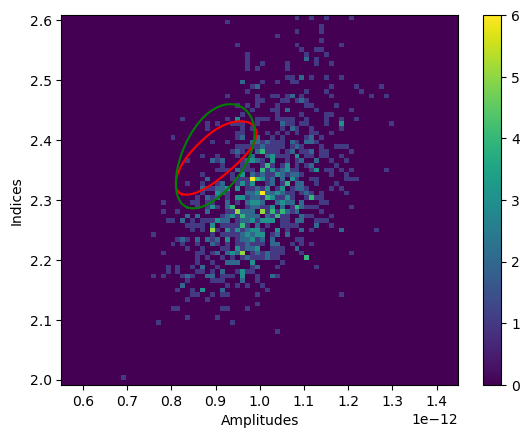

In [69]:
N_bins = N_new + 1
amplitude_bin = np.linspace(x_contour_N[0], x_contour_N[-1], N_bins )
index_bin = np.linspace(y_contour_N[0], y_contour_N[-1], N_bins )

amplitudes_data = valuies[1][:,0]
indices_data = valuies[2][:,0]
data_N_new, (abins, ibins) = np.histogramdd((amplitudes_data, indices_data), (amplitude_bin, index_bin))
fig, ax = plt.subplots()
im =ax.pcolormesh(abins,
           ibins,
           data_N_new)

fig.colorbar(im, ax=ax)

ax.set_xlabel("Amplitudes")
ax.set_ylabel("Indices")
plt.plot(dat[:,0],dat[:,1], color = 'red')
plt.plot(dat_N[:,0],dat_N[:,1], color = 'green')

In [70]:
def compute_inside(Ls_new, x_new,
               y_new, threshold,  find_min = False,  delta=1
                 ):
    tot_int = np.sum(Ls_new)
    offset = Ls_new.min() + threshold
    outside = Ls_new* (Ls_new < offset)
    inside = Ls_new* (Ls_new >= offset)

    return outside
    

In [71]:
threshold_contour = 1
outside_N = compute_inside(
    data_contour_N, x_contour_N,
           y_contour_N,  threshold_contour,  find_min = True, delta =1 )

outside = compute_inside(
    data_contour, x_contour,
           y_contour,  threshold_contour,  find_min = True, delta =1 )

Text(0.5, 1.0, 'Likelihood 0.0525')

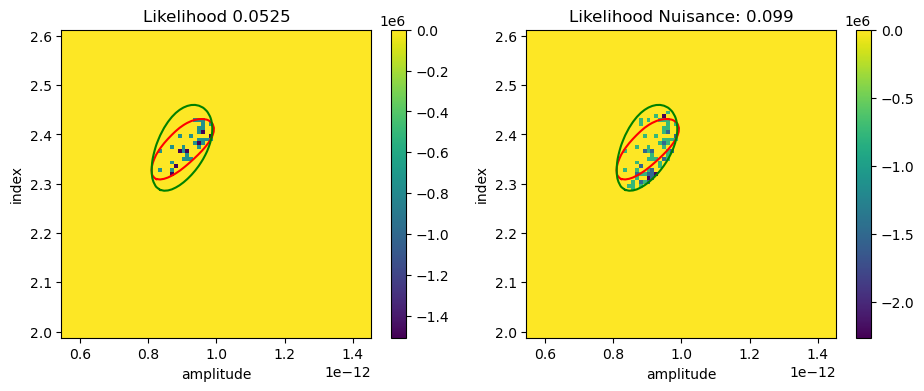

In [72]:
masked_N =  data_N_new * outside_N
masked =  data_N_new * outside

fig, (ax, ax2) = plt.subplots(1,2, figsize = (11,4))
im =ax.pcolormesh(x_contour,
           y_contour, masked)

fig.colorbar(im, ax=ax)
im =ax2.pcolormesh(x_contour,
           y_contour, masked_N)

fig.colorbar(im, ax=ax2)
for a in [ax, ax2]:
    a.set_xlabel("amplitude")
    a.set_ylabel("index",)
    a.plot(dat[:,0],dat[:,1], color = 'red')
    a.plot(dat_N[:,0],dat_N[:,1], color = 'green')

fraction_within_2d_N = np.count_nonzero(masked_N) /  np.count_nonzero(data_N_new)
fraction_within_2d = np.count_nonzero(masked) /  np.count_nonzero(data_N_new)

ax2.set_title(f"Likelihood Nuisance: {fraction_within_2d_N:.3}")
ax.set_title(f"Likelihood {fraction_within_2d:.3}")

## Interpolation:

In [73]:
N_bins_inter = 20
amplitude_bin = np.linspace(x_contour_N[0], x_contour_N[-1], N_bins_inter )

index_bin = np.linspace(y_contour_N[0], y_contour_N[-1], N_bins_inter )

amplitudes_data = valuies[1][:,0]
indices_data = valuies[2][:,0]
data, (abins, ibins) = np.histogramdd((amplitudes_data, indices_data), (amplitude_bin, index_bin))


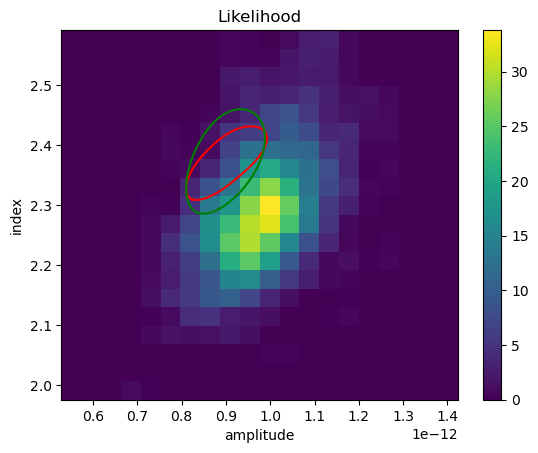

In [74]:

x = abins[:-1]
y = ibins[:-1]
x_new =  np.linspace(x[0], x[-1],N_bins_inter)
y_new =  np.linspace(y[0], y[-1],N_bins_inter)


f = interp2d(x = x, y= y, z = data, kind='linear',fill_value = None, bounds_error = False )
Ls_new = f(x_new, y_new)
fig, ax = plt.subplots()
im =ax.pcolormesh(x_new,
           y_new,
           Ls_new)

fig.colorbar(im, ax=ax)

plt.xlabel("amplitude")
plt.ylabel("index",)
plt.title(f"Likelihood")
ax.plot(dat[:,0],dat[:,1], color = 'red')
ax.plot(dat_N[:,0],dat_N[:,1], color = 'green')

(array([74]),)


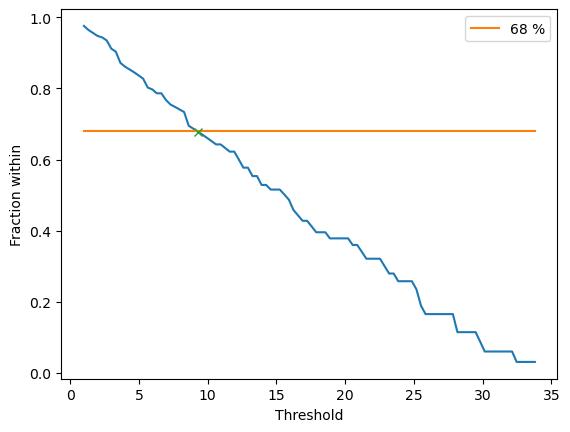

In [75]:
thresholds = np.linspace(np.max(Ls_new), 1, 100)
fractions  =  [compute_fraction(Ls_new, x_new,
               y_new, t) for t in thresholds]




plt.plot(thresholds,fractions)
epsilon = 1e-2
idx_68 = np.where(np.isclose(fractions, 0.68, epsilon) )
print(idx_68)
threshold = thresholds[idx_68[0][0]]


plt.plot(thresholds, [0.68]* len(thresholds), label = '68 %' )
plt.plot(threshold,compute_fraction(Ls_new, x_new,
               y_new, threshold) , 'x')
plt.xlabel("Threshold")
plt.ylabel("Fraction within")
plt.legend()

1.0211496429684237e-12 2.314531555679529
1.0211496429684237e-12 2.314531555679529


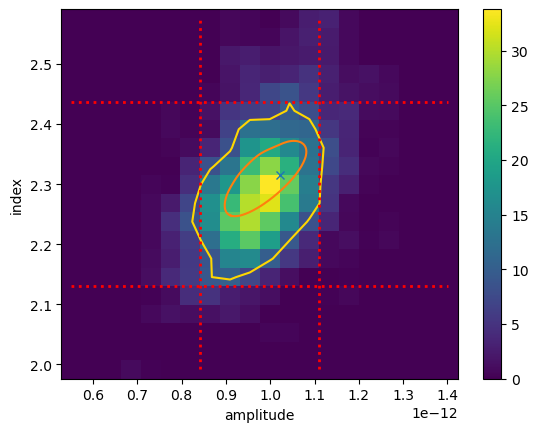

In [76]:
index_min, index_max,  ampli_min,  ampli_max , index_best,  ampli_best= compute_errors(Ls_new,x_new,
               y_new,  threshold, find_min =  False )

plot_L(Ls_new,x_new, y_new,  threshold, find_min =  False )
plt.plot(dat0[:,0],dat0[:,1])

## 1D histos

In [32]:
within_Ls = [0., 
               fraction_within(ampli_min,  
                               ampli_max,
                               amplitudes
                              ),
                fraction_within(index_min, index_max,
                               indices
                              )]

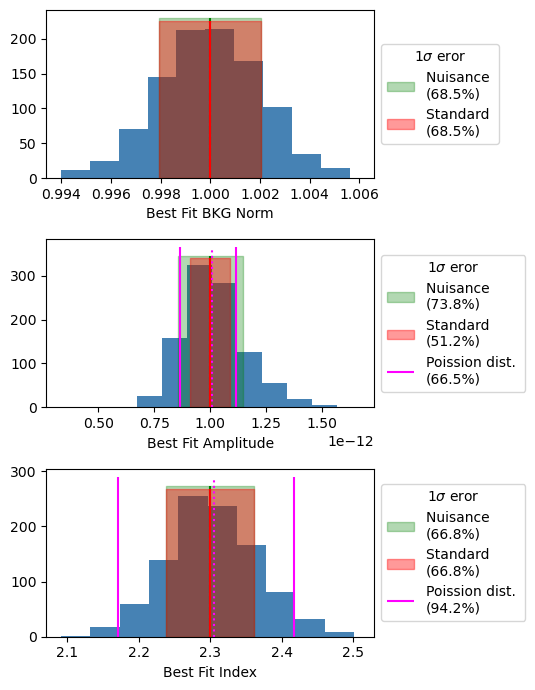

In [33]:
fig, axs = plt.subplots(3,1, figsize = (4,7))
xlabels = ["Best Fit BKG Norm", "Best Fit Amplitude", "Best Fit Index"]
legends = ["Nuisance", 'Standard'  , ]

for i, v in enumerate(valuies):
    axs[i].hist(v[1:,0], color ='steelblue')
    ylim = axs[i].get_ylim()
    delta_ylim = 5
    
    axs[i].vlines(valuies_asimov_N[i][0], ylim[0], ylim[1]+ delta_ylim, color = 'green', 
                 linestyle= 'dashed', )
    axs[i].fill_between([valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
                         valuies_asimov_N[i][0] + valuies_asimov_N[i][1]]
                        , ylim[0], ylim[1]+ delta_ylim,
                       alpha = 0.3, color = 'green', 
                        label = legends[0] + f' \n({withins[i][1]*100 :.3}%)')
    axs[i].vlines(valuies_asimov[i][0], ylim[0], ylim[1], color = 'red')
    axs[i].fill_between([valuies_asimov[i][0] - valuies_asimov[i][1],
                         valuies_asimov[i][0] + valuies_asimov[i][1]]
                        , ylim[0], ylim[1],
                       alpha = 0.4 , color = 'red', 
                        label = legends[1] +  f' \n({withins[i][0]*100 :.3}%)'  )
    
    axs[i].set_xlabel(xlabels[i])  
    
    
    x = axs[i].get_xlim()
    deltax = np.max([ valuies_asimov[i][0] - x[0] , x[1] - valuies_asimov[i][0] ])
    axs[i].set_xlim(valuies_asimov[i][0] -deltax, 
                    valuies_asimov[i][0] + deltax)
    
ylim = axs[1].get_ylim()
delta_ylim = 3   
axs[1].vlines(ampli_min, ylim[0], ylim[1]+delta_ylim, color = 'fuchsia') 
axs[1].vlines(ampli_max, ylim[0], ylim[1]+delta_ylim, color = 'fuchsia',
              label = f'Poission dist. \n({within_Ls[1]*100 :.3}%)' )    
axs[1].vlines(ampli_best, ylim[0], ylim[1], color = 'fuchsia', linestyle='dotted')

ylim = axs[2].get_ylim()
delta_ylim = 3 
axs[2].vlines(index_min, ylim[0], ylim[1]+delta_ylim, color = 'fuchsia') 
axs[2].vlines(index_max, ylim[0], ylim[1]+delta_ylim, color = 'fuchsia',
                 label = f'Poission dist. \n({within_Ls[2]*100 :.3}%)' )      
axs[2].vlines(index_best, ylim[0], ylim[1], color = 'fuchsia', linestyle='dotted')
    
plt.tight_layout()
for a in axs:
    a.legend(title="1$\sigma$ eror",loc='center left', bbox_to_anchor=(1, 0.5))

